In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
%matplotlib inline
import matplotlib.pyplot as plt

import sys 
import inspect
import seaborn as sns
import os

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, color_map='viridis')
sc.logging.print_versions()

scanpy==1.5.1 anndata==0.7.1 umap==0.4.4 numpy==1.17.2 scipy==1.4.1 pandas==0.24.2 scikit-learn==0.22 statsmodels==0.11.0 python-igraph==0.7.1 louvain==0.6.1 leidenalg==0.8.1


In [2]:
PROTEIN='TP53'
DATA='/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-07-09'
results_prefix=DATA+'/'+PROTEIN+'/processed_data/A549.'+PROTEIN
FIGS=DATA+'/Figures'
os.system('mkdir -p '+FIGS)


0

In [3]:
adata=sc.read(results_prefix+'.raw.h5ad')
adata

Only considering the two last: ['.raw', '.h5ad'].
Only considering the two last: ['.raw', '.h5ad'].


AnnData object with n_obs × n_vars = 192000 × 33694 
    obs: 'batch'

In [4]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 3429 cells that have less than 200 genes expressed
filtered out 8855 genes that are detected in less than 3 cells


normalizing counts per cell
    finished (0:00:12)


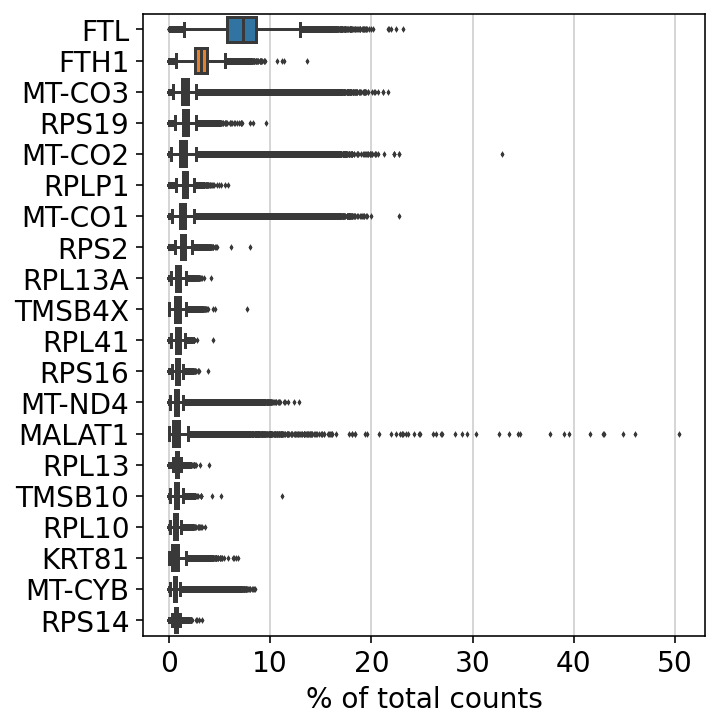

In [5]:
sc.pl.highest_expr_genes(adata, n_top=20, )

In [6]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

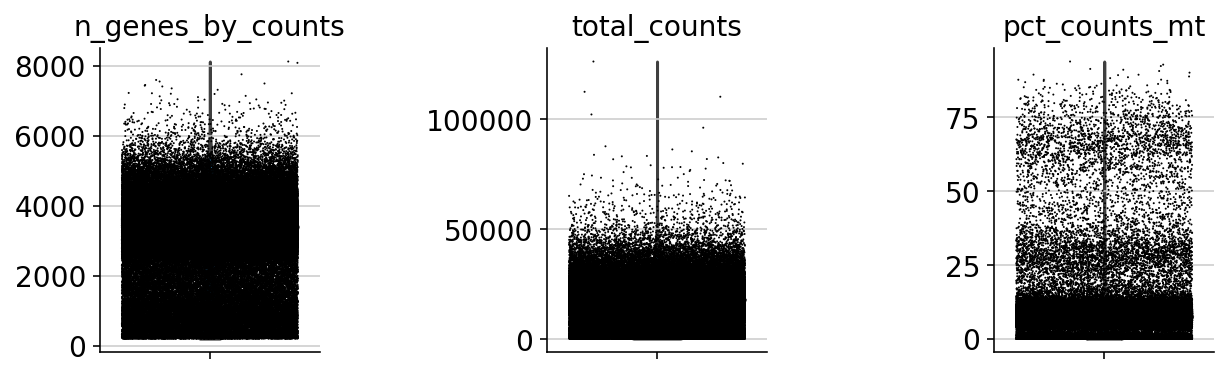

In [7]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

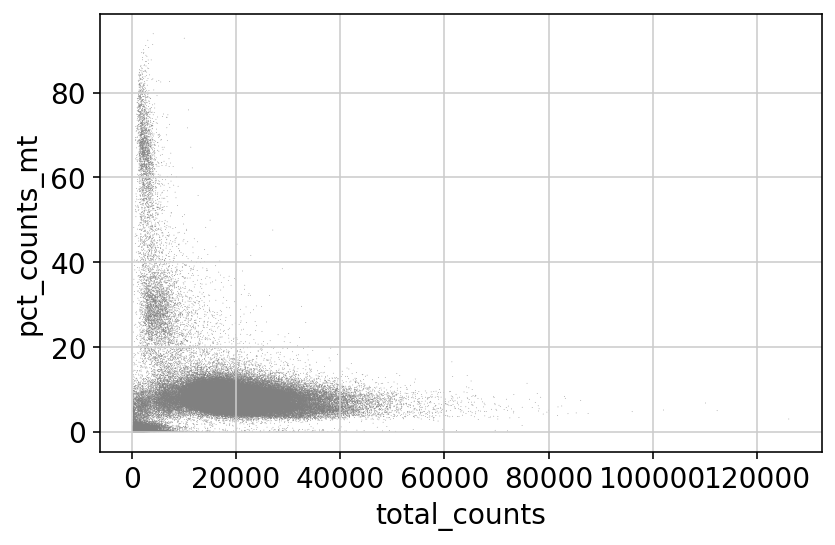

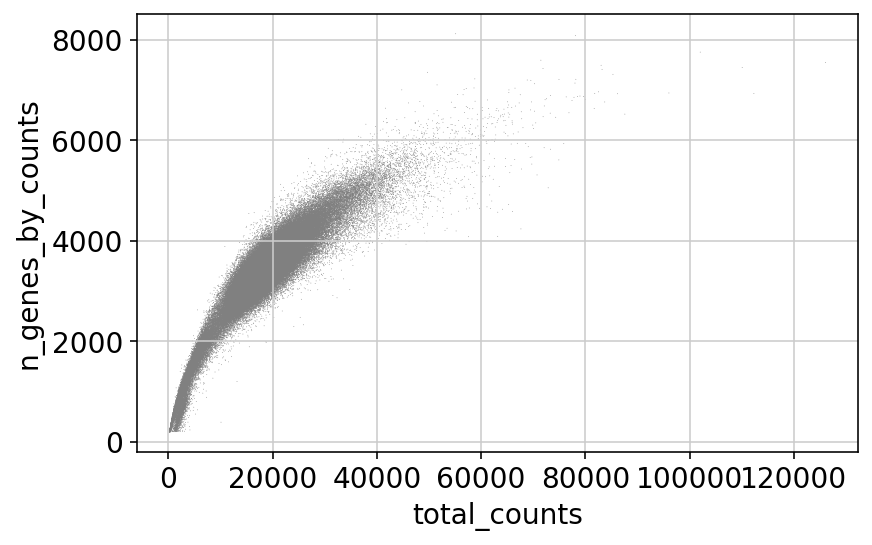

In [8]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [9]:
adatas={PROTEIN:adata}

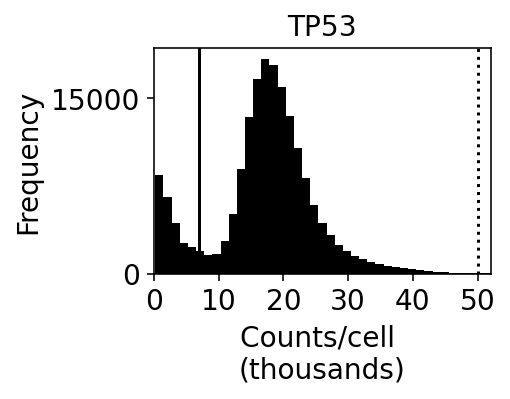

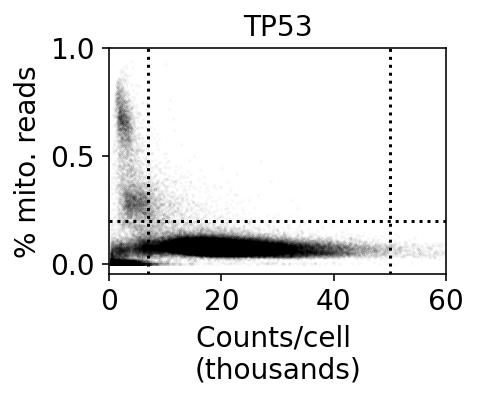

In [10]:
fw=3
fh=2

for protein in adatas:
    
    my_adata=adatas[protein]
    
    fig, plots = plt.subplots(1,1)
    fig.set_size_inches(fw,fh)
    plots.hist(my_adata.obs['total_counts']/1000,100,
             color='black')
    plots.set_xticks([0,10,20,30,40,50])
    plots.set_yticks([0,15000])
    plots.set_xlim(0,52)
    plots.set_xlabel('Counts/cell \n(thousands)')
    plots.set_ylabel('Frequency')
    plots.set_title(protein)
    plots.axvline(x=7,color='black')
    plots.axvline(x=50,linestyle='dotted',color='black')
    plots.grid(False)
    
    plt.savefig(FIGS+'/'+protein+'.Counts_hist.pdf',bbox_inches = "tight") 
    plt.savefig(FIGS+'/'+protein+'.Counts_hist.png',bbox_inches = "tight") 
    
    fig, plots = plt.subplots(1,1)
    fig.set_size_inches(fw,fh)
    plots.scatter(my_adata.obs['total_counts']/1000,my_adata.obs['pct_counts_mt']/100,
                 color='black',s=0.1,alpha=0.05)
    plots.set_yticks([0,0.5,1])

    #plots.set_yticks([0,0.1,0.2,0.3])
    plots.set_xlim(0,60)
    #plots.set_xticklabels(['0','5','>10'])
    plots.set_ylabel('% mito. reads')
    plots.set_xlabel('Counts/cell \n(thousands)')
    plots.set_title(protein)
    plots.axhline(y=0.2,linestyle='dotted',color='black')
    plots.axvline(x=7,linestyle='dotted',color='black')
    plots.axvline(x=50,linestyle='dotted',color='black')
    plots.grid(False)
    
    plt.savefig(FIGS+'/'+protein+'.Counts_vs_mito.pdf',bbox_inches = "tight")
    plt.savefig(FIGS+'/'+protein+'.Counts_vs_mito.png',bbox_inches = "tight")


In [11]:
#let's downsample to 50k
sc.pp.downsample_counts(adata, counts_per_cell=50000)

In [12]:
adata.obs['n_counts'] = adata.X.sum(axis=1).A1
max(adata.obs['n_counts'])

50000.0

In [13]:
adata = adata[adata.obs['n_counts'] > 7000, :]
adata = adata[adata.obs['n_counts'] <= 50000, :]
adata = adata[adata.obs['pct_counts_mt'] < 20, :]
print(adata)

View of AnnData object with n_obs × n_vars = 162314 × 24839 
    obs: 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'


In [14]:
adata.obs_names[:3]

Index(['AAACCTGAGAATGTTG-1-0', 'AAACCTGAGCTAGCCC-1-0', 'AAACCTGAGGTCGGAT-1-0'], dtype='object')

In [15]:
protein_obs=[]
batch_num=[]
new_obsnames=[]

for i in range(adata.n_obs):
    to_add=0
    protein_here=PROTEIN
    if protein_here=='KRAS':
        to_add=32
    batch_here=int(adata.obs_names[i].split('-1-')[1])+to_add
    protein_obs.append(protein_here)
    batch_num.append(batch_here)
    new_obsnames.append('ch'.join(adata.obs_names[i].split('-1-')))

In [20]:
adata.obs_names=new_obsnames

In [21]:
new_obsnames[:3]

['AAACCTGAGAATGTTGch0', 'AAACCTGAGCTAGCCCch0', 'AAACCTGAGGTCGGATch0']

In [22]:
adata.obs['protein']=protein_obs
adata.obs['channel']=batch_num

In [23]:
adata.write(results_prefix+'.filtered.h5ad')

In [24]:
adata=sc.read(results_prefix+'.filtered.h5ad')
adata

Only considering the two last: ['.filtered', '.h5ad'].
Only considering the two last: ['.filtered', '.h5ad'].


AnnData object with n_obs × n_vars = 162314 × 24839 
    obs: 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'protein', 'channel'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

Downsample by channel
===

In [25]:
channels=set(adata.obs['channel'])
print(channels)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31}


In [26]:
def subsample_counts(adata_here,subsampling_factor):
    import time
    from scipy.sparse import csr_matrix
    from scipy.sparse import coo_matrix
    #quickly loop through the sparse matrix of counts
    new_vals=[]
    nonzeros=adata_here.X.nonzero()
    m=adata_here.X
    nonzero_r=nonzeros[0]
    nonzero_c=nonzeros[1]
    start = time.time()
    
    m.eliminate_zeros()
    vals=m.data
    num_elts=len(vals)
    m_subsampled_data=[]#np.random.binomial(value,subsampling_prob)
    elt=0
    subsampling_prob=subsampling_factor
    print('nonzeros',num_elts)

    while elt<num_elts:
        if elt%5000000==0:
            end = time.time()
            print(elt,(end - start))
            start = time.time()
        m_subsampled_data.append(np.random.binomial(vals[elt],subsampling_prob,1)[0])
        elt+=1
    downsampled=csr_matrix((m_subsampled_data, m.indices, m.indptr), dtype=float,shape=m.shape)
    print(np.median(np.array(downsampled.sum(axis=1))))
    return(downsampled)

In [27]:
os.system('mkdir -p '+DATA+'/'+PROTEIN+'/subsampled')

0

In [28]:
SUBSAMPLED=DATA+'/'+PROTEIN+'/subsampled/'+PROTEIN
print(SUBSAMPLED)

/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-07-09/TP53/subsampled/TP53


In [29]:
import copy
subsampled={}

SUBS_COUNTS_LIST=[20000]

for channel in channels:
    for subs_counts in SUBS_COUNTS_LIST:
    
        curr_adata=adata[adata.obs['channel']==channel,:].copy()
        print(curr_adata)
        downsampled=copy.deepcopy(curr_adata)
        print(channel,subs_counts,curr_adata.shape)
        
        median_reads=np.median(np.array(downsampled.X.sum(axis=1)))
        subsampling_factor=int(1000.0*subs_counts/median_reads)/1000
        print('subsampling factor',subsampling_factor)
        outpath=SUBSAMPLED+'.channel'+str(channel)+'.counts_per_cell'+str(subs_counts)+'.h5ad'
        print(outpath)
            
        if subsampling_factor<1:
            downsampled.X=subsample_counts(downsampled,subsampling_factor) 
        downsampled.write(outpath)

AnnData object with n_obs × n_vars = 5373 × 24839 
    obs: 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'protein', 'channel'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
0 20000 (5373, 24839)
subsampling factor 1.005
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-07-09/TP53/subsampled/TP53.channel0.counts_per_cell20000.h5ad
AnnData object with n_obs × n_vars = 4943 × 24839 
    obs: 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'protein', 'channel'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
1 20000 (4943, 24839)
subsampling factor 0.992
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-07-09/TP53/subsampled/TP53.channel1.counts_per_cell20000.h5ad
nonzeros 1

16 20000 (4961, 24839)
subsampling factor 0.99
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-07-09/TP53/subsampled/TP53.channel16.counts_per_cell20000.h5ad
nonzeros 18780131
0 0.10030674934387207
5000000 78.85058188438416
10000000 77.96961116790771
15000000 77.98090744018555
20005.0
AnnData object with n_obs × n_vars = 5208 × 24839 
    obs: 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'protein', 'channel'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
17 20000 (5208, 24839)
subsampling factor 1.062
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-07-09/TP53/subsampled/TP53.channel17.counts_per_cell20000.h5ad
AnnData object with n_obs × n_vars = 4844 × 24839 
    obs: 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'p

In [30]:
#combine all downsampled channels into 1 file
import re
import copy

#read in 32 channels, merge
adatas={}

for counts in [20000]:

    print(counts)
    
    adatas={}
    for channel in range(32):
        print(channel)
        adata_here=sc.read(SUBSAMPLED+'.channel'+str(channel)+'.counts_per_cell'+str(counts)+'.h5ad',cache=False)
        adatas[channel]=copy.deepcopy(adata_here)
        
    ch1=copy.deepcopy(adatas[0])
    ch2=copy.deepcopy(adatas[1])
    ch3=copy.deepcopy(adatas[2])
    ch4=copy.deepcopy(adatas[3])
    ch5=copy.deepcopy(adatas[4])
    ch6=copy.deepcopy(adatas[5])
    ch7=copy.deepcopy(adatas[6])
    ch8=copy.deepcopy(adatas[7])
    ch9=copy.deepcopy(adatas[8])
    ch10=copy.deepcopy(adatas[9])
    ch11=copy.deepcopy(adatas[10])
    ch12=copy.deepcopy(adatas[11])
    ch13=copy.deepcopy(adatas[12])
    ch14=copy.deepcopy(adatas[13])
    ch15=copy.deepcopy(adatas[14])
    ch16=copy.deepcopy(adatas[15])
    ch17=copy.deepcopy(adatas[16])
    ch18=copy.deepcopy(adatas[17])
    ch19=copy.deepcopy(adatas[18])
    ch20=copy.deepcopy(adatas[19])
    ch21=copy.deepcopy(adatas[20])
    ch22=copy.deepcopy(adatas[21])
    ch23=copy.deepcopy(adatas[22])
    ch24=copy.deepcopy(adatas[23])
    ch25=copy.deepcopy(adatas[24])
    ch26=copy.deepcopy(adatas[25])
    ch27=copy.deepcopy(adatas[26])
    ch28=copy.deepcopy(adatas[27])
    ch29=copy.deepcopy(adatas[28])
    ch30=copy.deepcopy(adatas[29])
    ch31=copy.deepcopy(adatas[30])
    ch32=copy.deepcopy(adatas[31])

20000
0
Only considering the two last: ['.counts_per_cell20000', '.h5ad'].
Only considering the two last: ['.counts_per_cell20000', '.h5ad'].
1
Only considering the two last: ['.counts_per_cell20000', '.h5ad'].
Only considering the two last: ['.counts_per_cell20000', '.h5ad'].
2
Only considering the two last: ['.counts_per_cell20000', '.h5ad'].
Only considering the two last: ['.counts_per_cell20000', '.h5ad'].
3
Only considering the two last: ['.counts_per_cell20000', '.h5ad'].
Only considering the two last: ['.counts_per_cell20000', '.h5ad'].
4
Only considering the two last: ['.counts_per_cell20000', '.h5ad'].
Only considering the two last: ['.counts_per_cell20000', '.h5ad'].
5
Only considering the two last: ['.counts_per_cell20000', '.h5ad'].
Only considering the two last: ['.counts_per_cell20000', '.h5ad'].
6
Only considering the two last: ['.counts_per_cell20000', '.h5ad'].
Only considering the two last: ['.counts_per_cell20000', '.h5ad'].
7
Only considering the two last: ['.counts

24
Only considering the two last: ['.counts_per_cell20000', '.h5ad'].
Only considering the two last: ['.counts_per_cell20000', '.h5ad'].
25
Only considering the two last: ['.counts_per_cell20000', '.h5ad'].
Only considering the two last: ['.counts_per_cell20000', '.h5ad'].
26
Only considering the two last: ['.counts_per_cell20000', '.h5ad'].
Only considering the two last: ['.counts_per_cell20000', '.h5ad'].
27
Only considering the two last: ['.counts_per_cell20000', '.h5ad'].
Only considering the two last: ['.counts_per_cell20000', '.h5ad'].
28
Only considering the two last: ['.counts_per_cell20000', '.h5ad'].
Only considering the two last: ['.counts_per_cell20000', '.h5ad'].
29
Only considering the two last: ['.counts_per_cell20000', '.h5ad'].
Only considering the two last: ['.counts_per_cell20000', '.h5ad'].
30
Only considering the two last: ['.counts_per_cell20000', '.h5ad'].
Only considering the two last: ['.counts_per_cell20000', '.h5ad'].
31
Only considering the two last: ['.coun

In [31]:
a_concat=ch1.concatenate(ch2,ch3,ch4,ch5,ch6,ch7,ch8,ch9,ch10,
                         ch11,ch12,ch13,ch14,ch15,ch16,ch17,ch18,ch19,
                         ch20,ch21,ch22,ch23,ch24,ch25,ch26,ch27,ch28,ch29,
                         ch30,ch31,ch32)
a_concat
    

AnnData object with n_obs × n_vars = 162314 × 24839 
    obs: 'batch', 'channel', 'n_counts', 'n_genes', 'n_genes_by_counts', 'pct_counts_mt', 'protein', 'total_counts', 'total_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [32]:
a_concat.write(SUBSAMPLED+'.channel_1to32.counts_per_cell'+str(counts)+'.h5ad')

In [33]:
print(SUBSAMPLED+'.channel_1to32.counts_per_cell'+str(counts)+'.h5ad')

/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-07-09/TP53/subsampled/TP53.channel_1to32.counts_per_cell20000.h5ad
